In [1]:
# !pip install transformers
#!pip install pandas==1.3.0
#!pip install sklearn

Guide I've been using is here: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

Reviews Dataset: <a href="https://www.kaggle.com/volodymyrgavrysh/imdb-sentiment-10k-reviews-binary-classification">https://www.kaggle.com/volodymyrgavrysh/imdb-sentiment-10k-reviews-binary-classification</a>

In [1]:
import pandas as pd
#print(pd.__version__)
import re
import torch
print(torch.__version__)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertModel
  
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

#model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

1.10.0+cpu


In [2]:
twitter=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin1',header=None)

In [3]:
regexMap={r"<[\w'/'\s]*>": "",r"[\'\"\-]+": "",r"@[\w]+":"",r"http\S+" : ""}
def preprocess(datainput):
    t=datainput
    for regx in regexMap.keys():
        t = re.sub(regx, regexMap[regx], t)
    return t


In [4]:
#twitter.head()
twitter=twitter[[0,5]]
twitter

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
#twitter.head()
twitter[5]=twitter[5].apply(preprocess)

In [6]:
twitter

,0,5
0,0,"Awww, thats a bummer. You shoulda got Davi..."
1,0,is upset that he cant update his Facebook by t...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, its not behaving at all. im mad. why am i..."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com Very cool to hear old Walt intervi...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
encodings = twitter[5].apply(lambda x : tokenizer.encode(x, max_length = 512))
encodings

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0          [101, 138, 2246, 2246, 2246, 117, 1115, 1116, ...
1          [101, 1110, 5737, 1115, 1119, 1169, 1204, 1198...
2          [101, 146, 12706, 1181, 1242, 1551, 1111, 1103...
3          [101, 1139, 2006, 1404, 5115, 1122, 8992, 1105...
4          [101, 1185, 117, 1157, 1136, 1129, 22300, 1120...
                                 ...                        
1599995    [101, 2066, 7994, 1146, 119, 5823, 1185, 1278,...
1599996    [101, 1109, 24480, 2064, 119, 3254, 6424, 4348...
1599997    [101, 2372, 1128, 2407, 1111, 1240, 12556, 453...
1599998    [101, 8325, 24399, 16168, 1106, 1139, 171, 565...
1599999        [101, 2816, 108, 6630, 7926, 1279, 6194, 102]
Name: 5, Length: 1600000, dtype: object

C:\Users\Nick\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

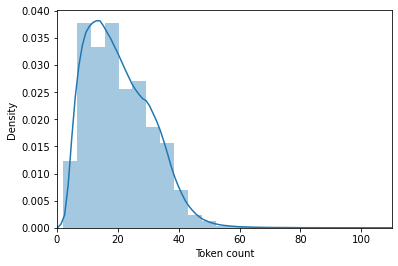

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(encodings.apply(len))
plt.xlim([0, 110])
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 80

In [9]:
encodings_plus = twitter[5].apply(lambda x : tokenizer.encode_plus(x, 
                                                              max_length = 80, 
                                                              add_special_tokens = True, 
                                                              return_token_type_ids = False, 
                                                              pad_to_max_length = True,
                                                              return_attention_mask = True,
                                                              return_tensors = 'pt'))
encodings_plus

C:\Users\Nick\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0          [input_ids, attention_mask]
1          [input_ids, attention_mask]
2          [input_ids, attention_mask]
3          [input_ids, attention_mask]
4          [input_ids, attention_mask]
                      ...             
1599995    [input_ids, attention_mask]
1599996    [input_ids, attention_mask]
1599997    [input_ids, attention_mask]
1599998    [input_ids, attention_mask]
1599999    [input_ids, attention_mask]
Name: 5, Length: 1600000, dtype: object

In [23]:
twitter["IDs"] = encodings_plus.apply(lambda x : x["input_ids"][0])
twitter["Masks"] = encodings_plus.apply(lambda x : x["attention_mask"][0])
twitter

,0,5,IDs,Masks
0,0,"Awww, thats a bummer. You shoulda got Davi...","[tensor(101), tensor(138), tensor(2246), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,0,is upset that he cant update his Facebook by t...,"[tensor(101), tensor(1110), tensor(5737), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,0,I dived many times for the ball. Managed to s...,"[tensor(101), tensor(146), tensor(12706), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,0,my whole body feels itchy and like its on fire,"[tensor(101), tensor(1139), tensor(2006), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,0,"no, its not behaving at all. im mad. why am i...","[tensor(101), tensor(1185), tensor(117), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,"[tensor(101), tensor(2066), tensor(7994), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1599996,4,TheWDB.com Very cool to hear old Walt intervi...,"[tensor(101), tensor(1109), tensor(24480), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,"[tensor(101), tensor(2372), tensor(1128), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,"[tensor(101), tensor(8325), tensor(24399), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


C:\Users\Nick\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='count'>

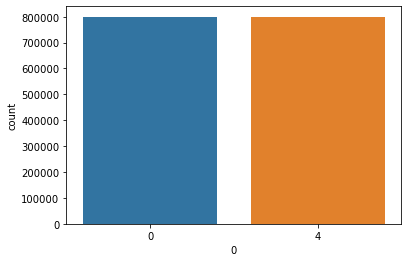

In [11]:
sns.countplot(twitter[0])

In [24]:
model = BertModel.from_pretrained("bert-base-cased")
example_tweets = twitter[:10]
example_tweets

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,0,5,IDs,Masks
0,0,"Awww, thats a bummer. You shoulda got Davi...","[tensor(101), tensor(138), tensor(2246), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,0,is upset that he cant update his Facebook by t...,"[tensor(101), tensor(1110), tensor(5737), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,0,I dived many times for the ball. Managed to s...,"[tensor(101), tensor(146), tensor(12706), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,0,my whole body feels itchy and like its on fire,"[tensor(101), tensor(1139), tensor(2006), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,0,"no, its not behaving at all. im mad. why am i...","[tensor(101), tensor(1185), tensor(117), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
5,0,not the whole crew,"[tensor(101), tensor(1136), tensor(1103), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
6,0,Need a hug,"[tensor(101), tensor(12528), tensor(170), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
7,0,"hey long time no see! Yes.. Rains a bit ,onl...","[tensor(101), tensor(23998), tensor(1263), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
8,0,nope they didnt have it,"[tensor(101), tensor(1185), tensor(3186), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
9,0,que me muera ?,"[tensor(101), tensor(15027), tensor(1143), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [25]:
for _, row in example_tweets.iterrows():
    pooled_output = model(input_ids = row["IDs"], attention_mask = row["Masks"])[1]
    drop = torch.nn.Dropout(p=0.3)
    output = drop(pooled_output)
    print(torch.nn.Linear(model.config.hidden_size, 2)(output))

ValueError: not enough values to unpack (expected 2, got 1)

In [17]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.drop = torch.nn.Dropout(p=0.3)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentClassifier(2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
input_ids = example_tweets["IDs"]
attention_mask = example_tweets["Masks"]


0    [[tensor(101), tensor(138), tensor(2246), tens...
1    [[tensor(101), tensor(1110), tensor(5737), ten...
2    [[tensor(101), tensor(146), tensor(12706), ten...
3    [[tensor(101), tensor(1139), tensor(2006), ten...
4    [[tensor(101), tensor(1185), tensor(117), tens...
5    [[tensor(101), tensor(1136), tensor(1103), ten...
6    [[tensor(101), tensor(12528), tensor(170), ten...
7    [[tensor(101), tensor(23998), tensor(1263), te...
8    [[tensor(101), tensor(1185), tensor(3186), ten...
9    [[tensor(101), tensor(15027), tensor(1143), te...
Name: IDs, dtype: object

# Loading Dataset File

In [9]:
#df=pd.read_csv('imdb_10K_sentimnets_reviews.csv')

In [10]:
#df.head()

# Split Dataset for training and testing

In [11]:
#training_dataset=df.sample(frac=0.7)
#test_dataset=df.drop(training_dataset.index)
training_dataset=twitter.sample(frac=0.7)
test_dataset=twitter.drop(training_dataset.index)

In [12]:
training_dataset.head()

,0,5
1258794,4,is planning stuff for this week...
307991,0,are you dating anyone? ALSO YES I DID kou is ...
483812,0,I know how you feel my ipod decided to stop ...
1270289,4,kickin it at s house with everyone. cool cro...
90648,0,no! I never found my selma! oh well! May...


In [13]:
print(len(training_dataset))
print(len(test_dataset))

1120000
480000


In [14]:
training_dataset['review'][6800]

KeyError: 'review'

In [ ]:
training_dataset['review']=training_dataset['review'].apply(preprocess)
test_dataset['review']=test_dataset['review'].apply(preprocess)

In [ ]:
training_dataset['review'][6800]

In [ ]:
vectorizer = CountVectorizer()

# Fit Count Vectorizer on training data

In [ ]:
vectorizer.fit(training_dataset['review'].values)

In [ ]:
vectorizer.vocabulary_

## Stopwords

In [ ]:
stop_words_vectorizer=CountVectorizer(stop_words='english')
stop_words_vectorizer.fit(training_dataset['review'].values)


In [ ]:
stop_words_vectorizer.vocabulary_

In [ ]:
x_input=stop_words_vectorizer.transform(training_dataset['review'].values)
x_test_input=stop_words_vectorizer.transform(test_dataset['review'].values)

In [ ]:
nb = MultinomialNB()

In [ ]:
nb.fit(x_input,training_dataset['sentiment'])

In [ ]:
y_pred_class = nb.predict(x_test_input)
metrics.accuracy_score(test_dataset["sentiment"].values, y_pred_class)

In [ ]:
print(classification_report(y_true=test_dataset["sentiment"].values,y_pred=y_pred_class))

In [ ]:
len(training_dataset[(training_dataset['sentiment']==1)])

In [ ]:
df_copy=test_dataset.copy()
df_copy['sentiment']=y_pred_class

In [ ]:
df_copy.head()
df_copy[df_copy['sentiment']==1]

In [ ]:
df_copy['review'][22]